# Tutorial on Wannier Berri : interpolating bands, Berry curvatures, and integrating them

The tutorial will focus on tetrahedron grids

In this tutorial we will see how to compute band energies, Berry curvature, spins and anomalous Hall conductivity  using WannierBerri code and further integrate them over the Brillouin zone to obtain Anomalous Hall conductivity, and other quantities of interest.





In [1]:
# Preliminary 

# Set environment variables - not mandatory but recommended if you use Parallel()
#import os
#os.environ['OPENBLAS_NUM_THREADS'] = '1' 
#os.environ['MKL_NUM_THREADS'] = '1'


import wannierberri as wberri
import pickle
print (f"Using WannierBerri version {wberri.__version__}")
import numpy as np
import scipy
import matplotlib.pyplot as plt
from termcolor import cprint

#  This block is needed if you run this cell for a second time
#  because one cannot initiate two parallel environments at a time
try:
    parallel.shutdown()   
except NameError:
    pass

# Chiose one of the options:

parallel = wberri.Parallel(num_cpus=4)
#parallel = wberri.Parallel()  # automatic detection 
#parallel = wberri.Serial()



Using WannierBerri version 0.13.5


2023-03-22 16:26:52,762	INFO worker.py:1519 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


## Reading the system

In this example we use data stored in the form of a Sparse model. This is a low-precision model, but it describes the valence band of Tellurium reasonably well. Please, update the paths if needed

In [2]:
param = pickle.load(open("../tests/data/Te_sparse/parameters_Te_low.pickle","rb"))
system = wberri.system.SystemSparse(**param)
x=0.259
system.symmetrize(
    # positions: positions of each atoms in a unitcell (direct coordinate system)
    positions = np.array([[x, 0 , 1./3],
                    [1-x, 1-x, 0],
                   [0.0, x, 2./3]]),
    # atom_name: name of each atoms, need to correspond to position order.
    atom_name = ['Te','Te','Te'],
    # projections: should be the same with projection card in wannier90.win
    proj = ['Te:s','Te:p'],
    # soc: with soc or spinless
    soc=True,
    # DFT_code: What code was used to complet the DFT calculation. only support VASP and QE now.
    DFT_code='vasp',
    )

generators=["C3z","C2y","TimeReversal"]
system.set_symmetry(generators)
print ("Number of R-vecotors used in the model:",(len(param['matrices']['Ham'].keys()))) 

(24, 24, 23)
NOT using ws_dist
Number of wannier functions: 24
Number of R points: 23
Recommended size of FFT grid [5 5 3]
Wannier atoms info
(1, 'Te', array([0.259     , 0.        , 0.33333333]), ['s', 'p'], [[0, 12], [3, 4, 5, 15, 16, 17]])
(2, 'Te', array([0.741, 0.741, 0.   ]), ['s', 'p'], [[1, 13], [6, 7, 8, 18, 19, 20]])
(3, 'Te', array([0.        , 0.259     , 0.66666667]), ['s', 'p'], [[2, 14], [9, 10, 11, 21, 22, 23]])
[get_spacegroup]
  Spacegroup is P3_121 (152).
  ---------------    1 ---------------
 det =  0.9999999999999998
  rotation:                    cart:
     [ 1  0  0]                    [1.00 0.00 0.00]
     [ 0  1  0]                    [0.00 1.00 0.00]
     [ 0  0  1]                    [0.00 0.00 1.00]
  translation:
     ( 0.00000  0.00000  0.00000)  ( 0.00000  0.00000  0.00000)
  ---------------    2 ---------------
 det =  0.9999999999999999
  rotation:                    cart:
     [ 0 -1  0]                    [-0.50 -0.87 0.00]
     [ 1 -1  0]           

## Let's plot the bandstructure first

calculator not described

calculator not described

Calculation along a path - checking calculators for compatibility
tabulate <wannierberri.calculators.TabulatorAll object at 0x7f91641758b0>
All calculators are compatible
Symmetrization switched off for Path
Grid is regular
The set of k points is a Path() with 228 points and labels {0: 'A', 17: 'G', 51: 'H', 81: 'A', 107: 'L', 122: 'H', 139: 'K', 169: 'G', 195: 'M', 210: 'L', 227: 'M'}
generating K_list
Done 
Done, sum of weights:228
symgroup : None
processing 228 K points : using  4 processes.
# K-points calculated  Wall time (sec)  Est. remaining (sec)
time for processing    228 K-points on   4 processes:     1.8947 ; per K-point          0.0083 ; proc-sec per K-point          0.0332
time1 =  0.010464668273925781
Totally processed 228 K-points 


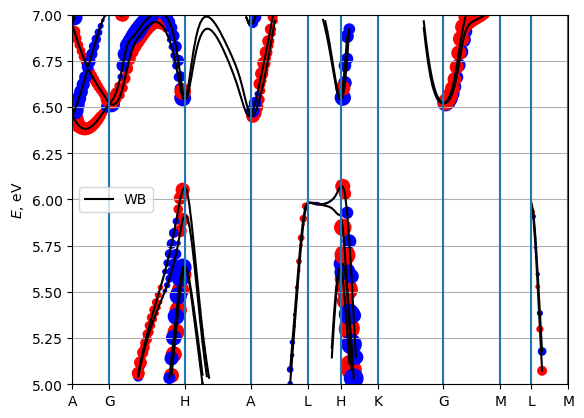

In [ ]:

nodes = {
            "A" : [0, 0, 1/2 ],
            "L" : [0, 1/2, 1/2 ],
            "M" : [0, 1/2, 0 ],
            "G" : [0, 0, 0 ],
            "H" : [1/3, 1/3, 1/2], 
            "K" : [1/3, 1/3, 0 ], 
            None : None
}

tabulators = { "Energy": wberri.calculators.tabulate.Energy(),
               "berry" : wberri.calculators.tabulate.BerryCurvature(kwargs_formula={"external_terms":False}),
             }
tab_all_path = wberri.calculators.TabulatorAll(
                    tabulators,
                    mode = "path")



def plotbands(path,Emin=5,Emax=7):

    result=wberri.run(system, 
                  grid=path, 
                  calculators = {"tabulate" : tab_all_path},
                  parallel = parallel, 
                  print_Kpoints = False)

    path_result = result.results["tabulate"]
    path_result.plot_path_fat( path,
              quantity="berry",
              component="z",
              save_file=None,
              Eshift=0,
              Emin=Emin,  Emax=Emax,
              iband=None,
              mode="fatband",
              fatfactor=20,
              cut_k=False, 
              close_fig=False,
              show_fig=False,
              label = "WB"
              )

    plt.legend()
    plt.grid()
    plt.show()
    plt.close()

pth = list("AGHALHKGMK")+[None,"L","M"]
path=wberri.Path(system,
                 nodes=[ nodes[k] for k in pth ],
                 labels=[s for s in pth if s is not None],
                 length=200 )     
    
plotbands(path)

In [50]:
list("asv")

['a', 's', 'v']

## Now have a closer look near H point VBM

Calculation along a path - checking calculators for compatibility
tabulate <wannierberri.calculators.TabulatorAll object at 0x7f91641758b0>
All calculators are compatible
Symmetrization switched off for Path
Grid is regular
The set of k points is a Path() with 84 points and labels {0: '$\\Gamma\\leftarrow$', 26: 'H', 48: 'L$\\leftarrow$', 70: 'H', 83: '$\\rightarrow$ K'}
generating K_list
Done 
Done, sum of weights:84
symgroup : None
processing 84 K points : using  4 processes.
# K-points calculated  Wall time (sec)  Est. remaining (sec)
time for processing     84 K-points on   4 processes:     0.5280 ; per K-point          0.0063 ; proc-sec per K-point          0.0251
time1 =  0.0020890235900878906
Totally processed 84 K-points 


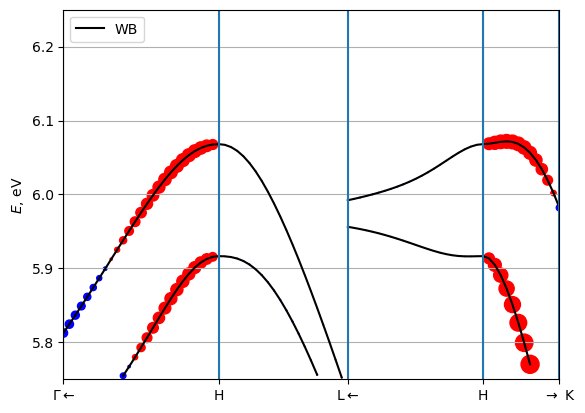

In [ ]:
x = 0.15
path=wberri.Path(system,
     nodes=[
             np.array(nodes["G"])*x+np.array(nodes["H"])*(1-x),
              nodes["H"],
             np.array(nodes["A"])*x+np.array(nodes["H"])*(1-x),
         None,
             np.array(nodes["L"])*2*x+np.array(nodes["H"])*(1-2*x),
              nodes["H"],
             np.array(nodes["K"])*x+np.array(nodes["H"])*(1-x),
         
             ],
     labels=[r"$\Gamma\leftarrow$","H",r"$\rightarrow$ A",r"L$\leftarrow$","H",r"$\rightarrow$ K"],
     length=1000 ) 

plotbands(path,Emin=5.75,Emax=6.25)    

## now evaluate the DOS with different grids

In [6]:
calculators = {}

parameters = dict(
        Efermi = np.linspace(6.0,6.1,201),
        tetra=True
            )

internal = dict(kwargs_formula=dict(external_terms=False))
# Set a grid 
grid = wberri.Grid(system, length=200, NKFFT=[6,6,8] )   # length [ Ang] ~= 2*pi/dk

#calculators ["ohmic"] = wberri.calculators.static.Ohmic_FermiSea(**parameters)
#calculators ["dos"] = wberri.calculators.static.DOS(**parameters)
calculators ["cumdos"] = wberri.calculators.static.CumDOS(**parameters, Emax=6.1, hole_like=True)
calculators ["BD_sea"] = wberri.calculators.static.BerryDipole_FermiSea(**parameters,**internal)
calculators ["BD_sea_hole"] = wberri.calculators.static.BerryDipole_FermiSea(**parameters,**internal,Emax=6.1,hole_like=True)
#calculators ["BD_surf"] = wberri.calculators.static.BerryDipole_FermiSurf(**parameters,**internal)





determining grids from NK=None (<class 'NoneType'>), NKdiv=None (<class 'NoneType'>), NKFFT=[6, 6, 8] (<class 'NoneType'>)
length=200 was converted into NK=[52 52 34]
The grids were set to NKdiv=[9 9 4], NKFFT=[6 6 8], NKtot=[54 54 32]
Cumulative density of states

Berry curvature dipole (dimensionless)

        | With Fermi sea integral. Eq(29) in `Ref <https://www.nature.com/articles/s41524-021-00498-5>`_
        | Output: :math:`D_{\beta\delta} = \int [dk] \partial_\beta \Omega_\delta f`

Berry curvature dipole (dimensionless)

        | With Fermi sea integral. Eq(29) in `Ref <https://www.nature.com/articles/s41524-021-00498-5>`_
        | Output: :math:`D_{\beta\delta} = \int [dk] \partial_\beta \Omega_\delta f`



In [7]:
result = {}
for length in 300,:
    for grid in [
#        ("tetragonal", wberri.grid.GridTetra(system, length=length, NKFFT=NKFFT ) ),
#        ("trigonal",  wberri.grid.GridTrigonal(system, length=length, NKFFT=NKFFT ) ),
#        ("trigonalH-1",  wberri.grid.GridTrigonalH(system, length=length, NKFFT=1,x=1 ) ),
#        ("trigonalH-0.5",  wberri.grid.GridTrigonalH(system, length=length, NKFFT=1,x=0.5 ) ),
#        ("trigonalH-0.25",  wberri.grid.GridTrigonalH(system, length=length, NKFFT=1,x=0.25 ) ),
        ("trigonalH-0.15",  wberri.grid.GridTrigonalH(system, length=length, NKFFT=1,x=0.15 ) ),
#        ("trigonalH-0.1",  wberri.grid.GridTrigonalH(system, length=length, NKFFT=1,x=0.1 ) ),
 #       ("parallel", wberri.grid.Grid(system, length=length, NKFFT=NKFFT ) ),
                ]:
        result[(length,grid[0])] = wberri.run(system,
            grid=grid[1],
            calculators = calculators,
            parallel=parallel,
            adpt_num_iter=50,
            use_irred_kpt=True,
            symmetrize=True,
            fout_name='Te',
            suffix=f"{grid[0]}-{length}",
            print_Kpoints=False,
            restart=False,
            file_Klist="Klist_ahc.pickle"  # needed to restart a calculation in future
            )



reduced reciprocal lattice : 
 [[1.62891728 0.         0.        ]
 [0.81445864 1.41068372 0.        ]
 [0.         0.         1.06063223]]
using starting tetrahedra with vertices 
 [[[0.33333333 0.33333333 0.5       ]
  [0.33333333 0.33333333 0.425     ]
  [0.28333333 0.28333333 0.5       ]
  [0.38333333 0.23333333 0.5       ]]

 [[0.33333333 0.33333333 0.5       ]
  [0.33333333 0.33333333 0.575     ]
  [0.28333333 0.28333333 0.5       ]
  [0.38333333 0.23333333 0.5       ]]]
volumes of tetrahedra are [9.375e-05 9.375e-05], total = 0.00018749999999999976 
weights of tetrahedra are [0.001125 0.001125], total = 0.0022499999999999972 
generating starting K_list
coord in rec.lattice = [   0.333333  ,   0.295833 ,    0.481250 ], refinement level:0, factor = 0.0011249999999999986
0.16195084937649687
coord in rec.lattice = [   0.333333  ,   0.295833 ,    0.518750 ], refinement level:0, factor = 0.0011249999999999986
0.16195084937649684
maximal tetrahedron size for now is 9.374999999999988e-0

time for processing     14 K-points on   4 processes:     0.2152 ; per K-point          0.0154 ; proc-sec per K-point          0.0615
time1 =  0.0023474693298339844
time2 =  0.018599748611450195
sum of weights now :0.0022499999999999916
Writing file_Klist_factor_changed to Klist_ahc.changed_factors.txt
symgroup : <wannierberri.symmetry.Group object at 0x7f91c33ef190>
processing 14 K points : using  4 processes.
# K-points calculated  Wall time (sec)  Est. remaining (sec)
time for processing     14 K-points on   4 processes:     0.2258 ; per K-point          0.0161 ; proc-sec per K-point          0.0645
time1 =  0.0012977123260498047
time2 =  0.021762609481811523
sum of weights now :0.0022499999999999916
Writing file_Klist_factor_changed to Klist_ahc.changed_factors.txt
symgroup : <wannierberri.symmetry.Group object at 0x7f91c33ef190>
processing 10 K points : using  4 processes.
# K-points calculated  Wall time (sec)  Est. remaining (sec)
time for processing     10 K-points on   4 proce

time1 =  0.002531766891479492
time2 =  0.015973329544067383
sum of weights now :0.0022500000000000007
Writing file_Klist_factor_changed to Klist_ahc.changed_factors.txt
symgroup : <wannierberri.symmetry.Group object at 0x7f91c33ef190>
processing 14 K points : using  4 processes.
# K-points calculated  Wall time (sec)  Est. remaining (sec)
time for processing     14 K-points on   4 processes:     0.1987 ; per K-point          0.0142 ; proc-sec per K-point          0.0568
time1 =  0.0013394355773925781
time2 =  0.015311956405639648
sum of weights now :0.0022500000000000024
Writing file_Klist_factor_changed to Klist_ahc.changed_factors.txt
symgroup : <wannierberri.symmetry.Group object at 0x7f91c33ef190>
processing 16 K points : using  4 processes.
# K-points calculated  Wall time (sec)  Est. remaining (sec)
time for processing     16 K-points on   4 processes:     0.2172 ; per K-point          0.0136 ; proc-sec per K-point          0.0543
time1 =  0.0016567707061767578
time2 =  0.0161449

time for processing     16 K-points on   4 processes:     0.1925 ; per K-point          0.0120 ; proc-sec per K-point          0.0481
time1 =  0.0015223026275634766
time2 =  0.014525175094604492
sum of weights now :0.002250000000000004
Writing file_Klist_factor_changed to Klist_ahc.changed_factors.txt
symgroup : <wannierberri.symmetry.Group object at 0x7f91c33ef190>
processing 16 K points : using  4 processes.
# K-points calculated  Wall time (sec)  Est. remaining (sec)
time for processing     16 K-points on   4 processes:     0.2024 ; per K-point          0.0127 ; proc-sec per K-point          0.0506
time1 =  0.0024352073669433594
time2 =  0.014861822128295898
sum of weights now :0.002250000000000004
Writing file_Klist_factor_changed to Klist_ahc.changed_factors.txt
symgroup : <wannierberri.symmetry.Group object at 0x7f91c33ef190>
processing 16 K points : using  4 processes.
# K-points calculated  Wall time (sec)  Est. remaining (sec)
time for processing     16 K-points on   4 process

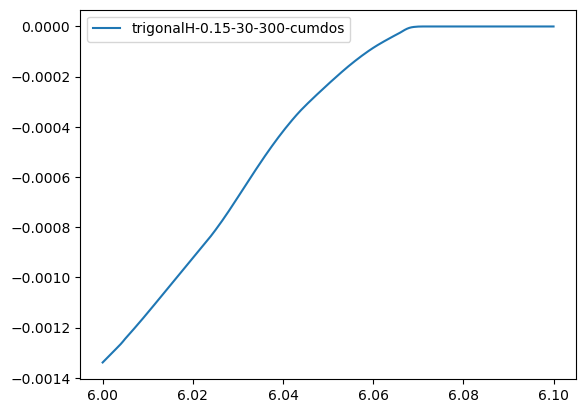

In [10]:
#plot results from different iterations

#for i in range(0,11,2):
for l in 300,:
    for i in 30,:
        for grid in [ "tetragonal",
                "parallel",
               # "trigonalH-0.1",
                "trigonalH-0.15",
                "trigonalH-0.25",
                ]:
            try:
#                a = np.loadtxt(f"Te-dos-{grid}-{l}_iter-{i:04d}.dat")
                a = np.loadtxt(f"Te-cumdos-{grid}-{l}_iter-{i:04d}.dat")
                plt.plot(a[:,0],a[:,1],label = f"{grid}-{i}-{l}-cumdos")
             #   plt.plot(a[:,0],a[:,1]-a[-1,1],label = f"{grid}-{i}-{l}-xx")
             #   a = np.loadtxt(f"Te-BD_sea-{grid}-{l}_iter-{i:04d}.dat")
             #   a = np.loadtxt(f"Te-BD_sea_hole-{grid}-{l}_iter-{i:04d}.dat")
             #   plt.plot(a[:,0],a[:,1]-a[-1,1],label = f"{grid}-{i}-{l}-xx")
             #   plt.plot(a[:,0],a[:,5]-a[-1,5],label = f"{grid}-{i}-{l}-yy")
             #   plt.plot(a[:,0],a[:,9]-a[-1,9],label = f"{grid}-{i}-{l}-zz")
             #   plt.plot(a[:,0],a[:,1]+a[:,9]+a[:,5],label = f"{grid}-{i}-{l}-trace")
             #   a = np.loadtxt(f"Te-BD_sea_hole-{grid}-{l}_iter-{i:04d}.dat")
             #   plt.plot(a[:,0],a[:,1]-a[-1,1],"--",label = f"{grid}-{i}-{l}-xx")
             #   plt.plot(a[:,0],a[:,5]-a[-1,5],"--",label = f"{grid}-{i}-{l}-yy")
             #   plt.plot(a[:,0],a[:,9]-a[-1,9],"--",label = f"{grid}-{i}-{l}-zz")
             #   plt.plot(a[:,0],a[:,1]+a[:,9]+a[:,5],"--",label = f"{grid}-{i}-{l}-trace")
                
            except:
                pass
            
            

#plt.ylim(-1000,1000)

plt.legend()

plt.show()

In [126]:
!ls Te-dos-parallel*iter-0030.dat



Te-dos-parallel-100_iter-0030.dat  Te-dos-parallel-300_iter-0030.dat
Te-dos-parallel-200_iter-0030.dat
